In [1]:
import os  # Provides functions to interact with the operating system, such as reading file names in directories
import json  # Used to read and parse JSON files, especially for country name mappings
import numpy as np  # Provides support for efficient numerical operations and array manipulations
import pandas as pd  # Enables structured data manipulation using DataFrames
from PIL import Image  # Part of the Pillow library, used for loading and processing image files
import seaborn as sns  # Built on top of matplotlib, used for more attractive and informative statistical graphics
import matplotlib.pyplot as plt  # For plotting charts and images
import cv2  # For advanced image processing 

### DataLoader Class

This class handles the loading and preprocessing of flag images from a specified folder, optionally mapping filenames to full country names using a JSON file.

---

#### Attributes:

- **`_folder_path`** *(protected)* – Path to the folder containing the flag images.
- **`_images`** *(protected)* – A list of loaded flag images stored as NumPy arrays.
- **`_image_names`** *(protected)* – A list of associated country names, either from the JSON file or derived from the filename.
- **`_country_map`** *(protected)* – Dictionary mapping country codes to full names, loaded from the JSON file.

---

#### Methods:

- **`__init__(self, folder_path, country_json_path=None)`**  
  Public constructor. Initializes the `DataLoader` with the folder path and optional path to a country mapping JSON file.

- **`_load_country_mapping(self, path)`** *(protected)*  
  Loads the country code-to-name mapping from a JSON file (e.g., `{ "US": "United States", "FR": "France" }`).

- **`_convert_filename_to_country(self, filename)`** *(protected)*  
  Extracts the country code from the filename and converts it to the full country name using the loaded mapping. If no match is found, it returns the filename itself.

- **`load_images(self, resize_shape=(100, 100))`**  
  Public method. Loads all `.png`, `.jpg`, and `.jpeg` images from the folder, resizes them to a consistent shape, converts them to NumPy arrays, and saves the associated names.

- **`get_data(self)`**  
  Public method. Returns two lists: the loaded image data and the corresponding list of country names.

In [2]:
# -------------------------
# DataLoader Class
# -------------------------
class DataLoader:
    def __init__(self, folder_path, country_json_path=None):
        self._folder_path = folder_path
        self._images = []
        self._image_names = []
        self._country_map = self._load_country_mapping(country_json_path) if country_json_path else {}

    def _load_country_mapping(self, path):
        with open(path, 'r', encoding='utf-8') as f:
            return json.load(f)

    def _convert_filename_to_country(self, filename):
        code = filename.split('.')[0].upper()
        return self._country_map.get(code, filename)

    def load_images(self, resize_shape=(100, 100)):
        for filename in os.listdir(self._folder_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    img_path = os.path.join(self._folder_path, filename)
                    img = Image.open(img_path).convert('RGB')
                    img = img.resize(resize_shape)
                    img_array = np.array(img)
                    self._images.append(img_array)
                    display_name = self._convert_filename_to_country(filename)
                    self._image_names.append(display_name)
                except Exception as e:
                    print(f"Error loading image {filename}: {e}")

    def get_data(self):
        return self._images, self._image_names

### FeatureExtractor Class

This class is responsible for extracting statistical and structural features from flag images, including the detection of visual symbols using change volatility analysis.

---

#### Attributes:

- **`_images`** *(protected)* – A list of loaded flag images as NumPy arrays.
- **`_image_names`** *(protected)* – Corresponding country names for each image.

---

#### Methods:

- **`__init__(self, images, image_names)`**  
  Public constructor. Initializes the `FeatureExtractor` with image data and country name metadata.

- **`_has_symbol(self, img)`** *(protected)*  
  Detects whether a flag image contains a symbol using volatility analysis:
  - Analyzes both rows and columns to detect significant color change patterns.
  - Flags are considered to have symbols based on the percentage of volatile rows/columns.
  - Returns:
    - `1.0` if a symbol is strongly present (detected both vertically and horizontally)
    - `0.5` if weakly present (only one direction volatile)
    - `0.0` if no symbol is likely

- **`extract_features(self)`**  
  Public method. Computes the following features for each image:
  - Mean of R, G, B channels
  - Standard deviation of R, G, B channels
  - Colorfulness (Euclidean norm of mean RGB)
  - Aspect ratio (width / height)
  - Symbol presence score via `_has_symbol`
  - Returns: A `pandas.DataFrame` with all features per flag

In [3]:
# -------------------------
# FeatureExtractor Class
# -------------------------
class FeatureExtractor:
    def __init__(self, images, image_names):
        self._images = images
        self._image_names = image_names

    def _has_symbol(self, img):
        """
        Detects presence of a symbol using visual volatility (column & row pixel changes).
        Returns:
        - 1.0 if symbol is clearly detected in both directions
        - 0.5 if detected in one direction
        - 0.0 if no symbol pattern is found
        """
        rows, cols, _ = img.shape

        def analyze_axis(data, axis_len, axis='column'):
            features = []
            for i in range(axis_len):
                change_count = 0
                change_magnitude = []

                for j in range(1, data.shape[1]):
                    if axis == 'column':
                        prev = data[j - 1, i].astype(np.int16)
                        curr = data[j, i].astype(np.int16)
                    else:
                        prev = data[i, j - 1].astype(np.int16)
                        curr = data[i, j].astype(np.int16)

                    diff = np.linalg.norm(curr - prev)
                    if diff > 20:
                        change_count += 1
                        change_magnitude.append(diff)

                volatility = np.std(change_magnitude) if change_magnitude else 0
                features.append((change_count, volatility))

            change_counts = np.array([f[0] for f in features])
            volatilities = np.array([f[1] for f in features])
            median_changes = np.median(change_counts)
            median_volatility = np.median(volatilities)

            outliers = sum(
                abs(change_counts[i] - median_changes) > 3 and 
                abs(volatilities[i] - median_volatility) > 15 
                for i in range(axis_len)
            )
            return outliers / axis_len > 0.1

        vertical_result = analyze_axis(img, cols, axis='column')
        horizontal_result = analyze_axis(img, rows, axis='row')

        if vertical_result and horizontal_result:
            return 1.0
        elif vertical_result or horizontal_result:
            return 0.5
        else:
            return 0.0

    def extract_features(self):
        """
        Public method to extract mean/std RGB, colorfulness, aspect ratio, and symbol detection.
        Returns a pandas DataFrame with features for all images.
        """
        features = []
        for img, name in zip(self._images, self._image_names):
            mean_color = np.mean(img, axis=(0, 1))
            std_color = np.std(img, axis=(0, 1))
            colorfulness = np.linalg.norm(mean_color)
            aspect_ratio = img.shape[1] / img.shape[0]
            symbol_present = self._has_symbol(img)

            features.append({
                'country': name,
                'mean_r': mean_color[0],
                'mean_g': mean_color[1],
                'mean_b': mean_color[2],
                'std_r': std_color[0],
                'std_g': std_color[1],
                'std_b': std_color[2],
                'colorfulness': colorfulness,
                'aspect_ratio': aspect_ratio,
                'has_symbol': symbol_present
            })

        return pd.DataFrame(features)

### Visualizer Class

The `Visualizer` class provides an interface for visualizing key metrics and relationships in the dataset, such as brightness, colorfulness, dominant color, and symbol presence among world flags.

---

#### Attributes:

- **`_df`** *(protected)* – A pandas DataFrame containing all the extracted features (e.g., RGB stats, brightness, colorfulness, etc.).

---

#### Methods:

- **`__init__(self, df)`**  
  Constructor. Initializes the visualizer with a DataFrame of flag features.

- **`plot_histogram(self, column)`**  
  Plots a histogram and KDE curve for a given numeric feature (e.g., brightness, colorfulness).

- **`plot_histograms(self)`**  
  Convenience method to plot multiple histograms (for colorfulness and brightness).

- **`plot_scatter(self, x, y)`**  
  Plots a scatter plot between any two numerical features.

- **`plot_relationships(self)`**  
  Combines `plot_scatter()` and `plot_pairplot()` to explore feature interactions visually.

- **`plot_box(self, column)`**  
  Visualizes the distribution, median, and outliers of a given feature using a boxplot.

- **`plot_bar_mean_brightness(self)`**  
  Horizontal bar chart of the top 20 flags sorted by average brightness.

- **`plot_pairplot(self)`**  
  Plots a seaborn pairplot between `mean_r`, `mean_g`, `mean_b`, and `colorfulness`.

- **`plot_top_colorful_flags(self)`**  
  Horizontal bar chart of the top 20 flags sorted by colorfulness.

- **`plot_top_flags(self)`**  
  Convenience method to run both `plot_bar_mean_brightness()` and `plot_top_colorful_flags()`.

- **`find_top_red_flags(self)`**  
  Prints the top 10 flags where red is the dominant color (based on `mean_r`).

- **`find_top_blue_flags(self)`**  
  Prints the top 10 flags where blue is dominant (based on `mean_b`).

- **`cluster_flags(self)`**  
  Performs K-Means clustering on selected color features and plots the clusters.

- **`find_most_variable_flags(self)`**  
  Identifies and prints the 10 flags with the highest color variability (based on RGB std deviation).

- **`find_brightest_and_darkest_flags(self)`**  
  Displays the 5 brightest and 5 darkest flags according to their computed brightness.

- **`plot_dominant_color_pie(self)`**  
  Pie chart showing the proportion of dominant colors (Red, Green, Blue) across all flags.

- **`has_symbol_display(self)`**  
  Displays both bar and pie charts representing symbol detection scores:  
  - `0.0`: No symbol  
  - `0.5`: Partially detected  
  - `1.0`: Clearly detected
 
- **`plot_color_palette_grid(self, grid_size=(10, 10))`**  
  Shows a grid where each flag is colored using its average RGB value.  
  Useful for observing dominant palettes across nations.

- **`plot_symbol_vs_colorfulness_boxplot(self)`**  
  Boxplot that compares colorfulness across symbol detection levels (0, 0.5, 1).  
  Helps analyze whether flags with symbols tend to be more or less colorful.


In [4]:
# -------------------------
# Visualizer Class
# -------------------------
class Visualizer:
    def __init__(self, df):
        self._df = df  # this is protected, allows subclassing or internal access but not meant for public manipulation

    def plot_histogram(self, column):
        # Plot histogram for a given numeric column
        plt.figure(figsize=(8, 5))
        sns.histplot(self._df[column], kde=True)
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()

    def plot_histograms(self):
        # Plot multiple histograms for important numeric features
        self.plot_histogram('colorfulness')
        self.plot_histogram('brightness')

    def plot_scatter(self, x, y):
        # Scatter plot between two columns
        plt.figure(figsize=(8, 5))
        sns.scatterplot(data=self._df, x=x, y=y)
        plt.title(f'{y} vs {x}')
        plt.xlabel(x)
        plt.ylabel(y)
        plt.show()

    def plot_relationships(self):
        # Plot relationships between RGB and colorfulness
        self.plot_scatter('mean_r', 'mean_b')
        self.plot_pairplot()

    def plot_box(self, column):
        # Boxplot for a specific column
        plt.figure(figsize=(8, 5))
        sns.boxplot(x=self._df[column])
        plt.title(f'Boxplot of {column}')
        plt.show()

    def plot_bar_mean_brightness(self):
        # Horizontal bar plot of top 20 brightest flags
        sorted_df = self._df.sort_values('brightness', ascending=False)
        plt.figure(figsize=(12, 6))
        sns.barplot(data=sorted_df.head(20), x='country', y='brightness')
        plt.xticks(rotation=90)
        plt.title('Top 20 Brightest Flags')
        plt.ylabel('Brightness')
        plt.xlabel('Country')
        plt.show()

    def plot_pairplot(self):
        # Pairplot between RGB mean values and colorfulness
        sns.pairplot(self._df[['mean_r', 'mean_g', 'mean_b', 'colorfulness']])
        plt.show()

    def plot_top_colorful_flags(self):
        # Bar chart of top 20 most colorful flags
        sorted_df = self._df.sort_values('colorfulness', ascending=False)
        plt.figure(figsize=(12, 6))
        sns.barplot(data=sorted_df.head(20), x='country', y='colorfulness')
        plt.xticks(rotation=90)
        plt.title('Top 20 Most Colorful Flags')
        plt.ylabel('Colorfulness')
        plt.xlabel('Country')
        plt.show()

    def plot_top_flags(self):
        # Plot both brightness and colorful rankings
        self.plot_bar_mean_brightness()
        self.plot_top_colorful_flags()

    def find_top_red_flags(self):
        red_flags = self._df[self._df['dominant_color'] == 'Red'].sort_values('mean_r', ascending=False)
        print("Top 10 Red Dominant Flags:")
        print(red_flags[['country', 'mean_r']].head(10))

    def find_top_blue_flags(self):
        blue_flags = self._df[self._df['dominant_color'] == 'Blue'].sort_values('mean_b', ascending=False)
        print("Top 10 Blue Dominant Flags:")
        print(blue_flags[['country', 'mean_b']].head(10))

    def cluster_flags(self):
        from sklearn.cluster import KMeans
        features = self._df[['mean_r', 'mean_g', 'mean_b', 'colorfulness']]
        kmeans = KMeans(n_clusters=4, random_state=0)
        self._df['cluster'] = kmeans.fit_predict(features)
        print("Cluster Assignments:")
        print(self._df[['country', 'cluster']].head())

        # Plot cluster visualization
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=self._df, x='mean_r', y='mean_b', hue='cluster', palette='tab10')
        plt.title('Clusters of Flags based on Colors')
        plt.xlabel('Mean Red')
        plt.ylabel('Mean Blue')
        plt.show()

    def find_most_variable_flags(self):
        # Calculate average standard deviation across RGB channels
        most_variable = self._df.copy()
        most_variable['std_total'] = most_variable[['std_r', 'std_g', 'std_b']].mean(axis=1)
        # Sort by highest variability
        top_var = most_variable.sort_values('std_total', ascending=False).head(10)
        print("Top 10 Most Variable Flags:")
        print(top_var[['country', 'std_total']])

    def find_brightest_and_darkest_flags(self):
        # Sort by brightness to get top and bottom 5 flags
        brightest = self._df.sort_values('brightness', ascending=False).head(5)
        darkest = self._df.sort_values('brightness', ascending=True).head(5)
        print("Brightest Flags:")
        print(brightest[['country', 'brightness']])
        print("\nDarkest Flags:")
        print(darkest[['country', 'brightness']])

    def plot_dominant_color_pie(self):
        # Plot a pie chart showing the proportion of dominant colors
        counts = self._df['dominant_color'].value_counts()

        plt.figure(figsize=(6, 6))
        plt.pie(
            counts,
            labels=counts.index,
            autopct='%1.1f%%',
            startangle=140,
            colors=['red', 'green', 'blue']
        )
        plt.title('Dominant Colors Distribution')
        plt.axis('equal')  # Ensure pie is a circle
        plt.show()

    def has_symbol_display(self):
        symbol_counts = self._df['has_symbol'].value_counts().sort_index()

        # Bar chart
        plt.figure(figsize=(6, 4))
        sns.countplot(x='has_symbol', data=self._df, palette='Set2', order=[0.0, 0.5, 1.0])
        plt.xticks([0, 1, 2], ['No Symbol (0)', 'Partial Detection (0.5)', 'Has Symbol (1)'])
        plt.title('Number of Flags With and Without Symbols')
        plt.xlabel('Symbol Detection Level')
        plt.ylabel('Number of Flags')
        plt.show()

        # Pie chart
        labels = ['No Symbol (0)', 'Partial (0.5)', 'Has Symbol (1)']
        values = [symbol_counts.get(0.0, 0), symbol_counts.get(0.5, 0), symbol_counts.get(1.0, 0)]

        plt.figure(figsize=(6, 6))
        plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'gold', 'salmon'])
        plt.title('Proportion of Flags by Symbol Detection')
        plt.axis('equal')
        plt.show()

    def plot_color_palette_grid(self, grid_size=(10, 10)):
        # Display a grid of flags with their dominant color as the background
        fig, axarr = plt.subplots(*grid_size, figsize=(16, 10))
        sorted_df = self._df.sort_values('colorfulness', ascending=False).reset_index()
        for i in range(grid_size[0]):
            for j in range(grid_size[1]):
                idx = i * grid_size[1] + j
                if idx >= len(sorted_df):
                    axarr[i, j].axis('off')
                    continue
                country = sorted_df.loc[idx, 'country']
                color = (
                    sorted_df.loc[idx, 'mean_r']/255,
                    sorted_df.loc[idx, 'mean_g']/255,
                    sorted_df.loc[idx, 'mean_b']/255
                )
                axarr[i, j].set_facecolor(color)
                axarr[i, j].text(0.5, 0.5, country, color='black', ha='center', va='center', fontsize=7)
                axarr[i, j].set_xticks([])
                axarr[i, j].set_yticks([])
        plt.suptitle('Flag Color Palette Grid', fontsize=16)
        plt.tight_layout()
        plt.show()

    def plot_symbol_vs_colorfulness_boxplot(self):
        # Boxplot of colorfulness grouped by symbol presence
        plt.figure(figsize=(8, 5))
        sns.boxplot(x='has_symbol', y='colorfulness', data=self._df, palette='Set2')
        plt.xticks([0, 1, 2], ['No Symbol (0)', 'Partial (0.5)', 'Has Symbol (1)'])
        plt.title('Symbol Presence vs. Colorfulness')
        plt.xlabel('Symbol Presence')
        plt.ylabel('Colorfulness')
        plt.show()


### DataAnalyzer Class

The `DataAnalyzer` class is responsible for performing statistical analysis and transformations on the DataFrame of extracted flag features. It handles data summarization, filtering, enhancement, and visualization of key relationships.

---

#### Attributes:

- **`_df`** *(protected)* – The DataFrame containing all extracted features from flag images, including color statistics, symbol detection, and shape descriptors.

---

#### Methods:

- **`__init__(self, df)`**  
  Initializes the class with a given DataFrame of image features.

- **`describe_data(self)`**  
  Returns a statistical summary of all numeric features using `pandas.DataFrame.describe()`.  
  If the DataFrame is empty, returns a message instead.

- **`filter_colorful_flags(self, threshold=150)`**  
  Filters and returns a subset of flags whose `colorfulness` exceeds the provided threshold.  
  Useful for identifying vibrant or visually striking flags.

- **`add_brightness_column(self)`**  
  Computes the average brightness of each flag using the mean of its RGB values and adds a new column `brightness` to the internal DataFrame.

- **`plot_correlation_matrix(self)`**  
  Creates a heatmap that shows correlations among selected numerical features (e.g., color channels, brightness, colorfulness, and aspect ratio).  
  Helps identify potential relationships or redundancies in the data.

- **`find_dominant_colors(self)`**  
  Determines which of the RGB channels is dominant for each flag and assigns a label (`Red`, `Green`, or `Blue`) to a new column `dominant_color`.  
  Also displays a countplot of how many flags fall into each dominant category.

- **`get_dataframe(self)`**  
  Returns the internal DataFrame `_df` for use by other classes (e.g., `Visualizer`).

In [5]:
# -------------------------
# DataAnalyzer Class
# -------------------------
class DataAnalyzer:
    def __init__(self, df):
        self._df = df  # protected, accessible to other classes if needed, but not public API

    def describe_data(self):
        # Returns basic statistical summary of the dataset
        if self._df.empty:
            return "No data to describe. Please check if any images were successfully loaded."
        return self._df.describe()

    def filter_colorful_flags(self, threshold=150):
        # Filters and returns flags with colorfulness above the given threshold
        return self._df[self._df['colorfulness'] > threshold]

    def add_brightness_column(self):
        # Adds a new column to the DataFrame, average brightness based on RGB means
        if not self._df.empty:
            self._df['brightness'] = (self._df['mean_r'] + self._df['mean_g'] + self._df['mean_b']) / 3

    def plot_correlation_matrix(self):
        # Plots a correlation heatmap for core color and shape metrics
        if not self._df.empty:
            plt.figure(figsize=(10, 8))
            corr = self._df[['mean_r', 'mean_g', 'mean_b', 'colorfulness', 'brightness', 'aspect_ratio']].corr()
            sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
            plt.title("Correlation Matrix")
            plt.show()
        else:
            print("DataFrame is empty. Cannot plot correlation matrix.")

    def find_dominant_colors(self):
        # Identifies and visualizes the dominant color for each flag (R/G/B)
        if not self._df.empty:
            def dominant_color(row):
                mean_colors = {'Red': row['mean_r'], 'Green': row['mean_g'], 'Blue': row['mean_b']}
                return max(mean_colors, key=mean_colors.get)

            self._df['dominant_color'] = self._df.apply(dominant_color, axis=1)

            print("Dominant Color Counts:")
            print(self._df['dominant_color'].value_counts())

            plt.figure(figsize=(6, 4))
            sns.countplot(x='dominant_color', data=self._df, palette='Set2')
            plt.title('Dominant Colors among Flags')
            plt.xlabel('Dominant Color')
            plt.ylabel('Number of Flags')
            plt.show()
        else:
            print("DataFrame is empty. Cannot determine dominant colors.")

    def get_dataframe(self):
        # Returns the internal dataframe
        return self._df


### Utility Functions for Flag Analysis Pipeline

These functions orchestrate the end-to-end flow of the project, from loading and preprocessing flag images to analyzing extracted features.

---

#### `load_data()`

- **Purpose**: Loads all flag images and maps them to their respective country names using a JSON lookup file.
- **Steps**:
  - Creates a `DataLoader` instance.
  - Loads images from the specified directory and resizes them.
  - Applies country name mapping via filename-to-country code conversion.
- **Returns**: A list of image arrays and a list of corresponding country names.

---

#### `extract_features(images, image_names)`

- **Purpose**: Extracts visual and statistical features from each image using the `FeatureExtractor` class.
- **Returns**: A pandas DataFrame containing:
  - Mean and standard deviation of R, G, B values
  - Colorfulness
  - Aspect ratio
  - Symbol presence score

---

#### `analyze(features_df)`

- **Purpose**: Performs data analysis on the extracted feature DataFrame using `DataAnalyzer`.
- **Steps**:
  - Prints descriptive statistics for all numeric columns.
  - Computes and adds a `brightness` column to the DataFrame.
  - Filters and displays flags with a `colorfulness` score above 150.
- **Returns**: An instance of the `DataAnalyzer` class for further exploration.

In [6]:
# Step 1: Load everything
def load_data():
    data_loader = DataLoader('./flags/all_flags', './flags/countries.json')
    data_loader.load_images()
    images, image_names = data_loader.get_data()
    return images, image_names

# Step 2: Extract features
def extract_features(images, image_names):
    extractor = FeatureExtractor(images, image_names)
    return extractor.extract_features()

# Step 3: Analyze
def analyze(features_df):
    analyzer = DataAnalyzer(features_df)
    print(analyzer.describe_data())
    analyzer.add_brightness_column()
    colorful = analyzer.filter_colorful_flags()
    print(f"Colorful Flags (>150):\n{colorful[['country', 'colorfulness']]}")
    return analyzer

In [7]:
#Load flag images and their corresponding country names and extract visual features from the images
images, image_names = load_data()
features_df = extract_features(images, image_names)

/Users/agrigoryan/anaconda3/lib/python3.11/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [8]:
#Analyze the extracted features such as describe stats, add brightness and filter colorful flags
analyzer = DataAnalyzer(features_df)  
analyzer.add_brightness_column()
print(analyzer.describe_data())
# Initialize the visualizer with the analyzed DataFrame for plotting and exploration
viz = Visualizer(analyzer.get_dataframe())

           mean_r      mean_g      mean_b       std_r       std_g       std_b  \
count  195.000000  195.000000  195.000000  195.000000  195.000000  195.000000   
mean   144.107284  111.391164  102.244953   88.480629   76.117980   65.534083   
std     54.771054   46.298782   56.754545   34.302375   25.645644   32.467396   
min     12.034300    0.000000    0.000000    0.000000    0.000000    0.000000   
25%    107.491600   84.796050   53.544100   78.790189   58.124598   37.344345   
50%    150.650000  110.956700   95.838000  102.910599   77.708630   71.182270   
75%    175.249800  140.482500  139.955150  110.677394   96.393359   92.273457   
max    255.000000  240.852600  236.779600  127.016259  127.016259  127.016259   

       colorfulness  aspect_ratio  has_symbol  brightness  
count    195.000000         195.0  195.000000  195.000000  
mean     220.216115           1.0    0.612821  119.247800  
std       58.934152           0.0    0.421815   35.403154  
min       85.256518           

### Statistical Summary of Flag Features

The table above summarizes visual features extracted from 195 world flags, including average color intensity, variability, color richness, aspect ratio, and symbol presence.



#### Key Insights from Summary Statistics

- Red dominates: The average red value (144.1) is higher than green (111.4) and blue (102.2), indicating a frequent use of red in flag designs.
- High colorfulness: Most flags are visually rich in color, with an average colorfulness of approximately 220 and a maximum of over 415.
- Standardized size: All aspect ratios are 1.0 due to resizing, so this feature has no variation in this dataset.
- Symbol presence:
  - About 61% of flags are marked as having symbols (mean = 0.61).
  - The `has_symbol` values indicate a mix of symbolic and minimalistic designs.

---

### Colorful Flags Above Threshold

A filtered list of flags with `colorfulness > 150` highlights vibrant national designs such as:

- Uruguay
- Nicaragua
- Montenegro
- South Africa
- Mauritania

These flags tend to use multiple vivid colors or highly saturated patterns.

---

### Summary

The dataset shows that most world flags are highly colorful, frequently red-dominant, and over 60 percent contain symbolic elements like icons, shields, or emblems.


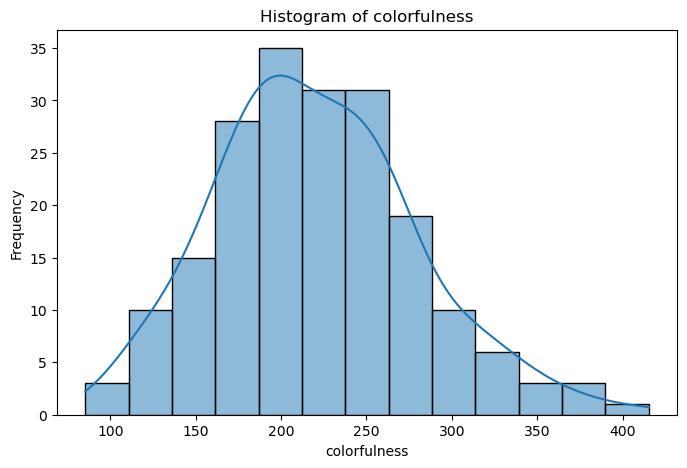

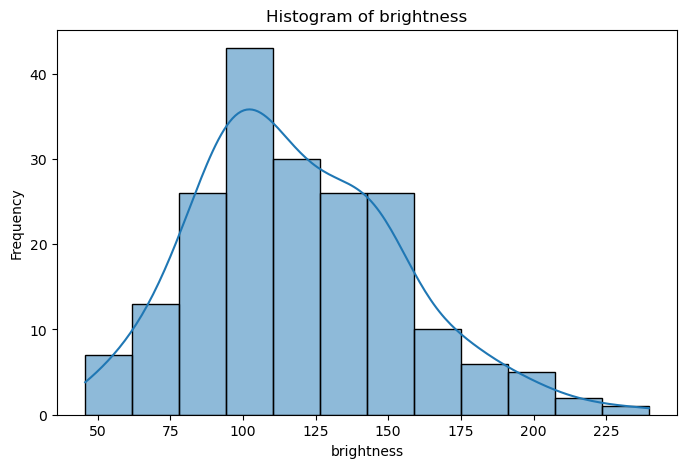

In [9]:
viz.plot_histograms()

### Histogram of Colorfulness

This histogram shows the distribution of colorfulness scores across all analyzed flags.

- The shape of the distribution is approximately normal (bell-shaped), centered around a colorfulness score of ~220.
- Most flags fall within the range of 150 to 300, indicating that flags are generally designed to be visually vibrant and colorful.
- A small number of flags reach colorfulness scores above 350, meaning they use extremely vivid or diverse colors.
- Very few flags have scores below 100, suggesting that muted or low-color designs are uncommon in national flags.

**Conclusion**: Color is a prominent element in flag design, with most flags exhibiting high levels of visual richness.

---

### Histogram of Brightness

This plot displays the distribution of average brightness values, calculated as the mean of red, green, and blue channels.

- The distribution is right-skewed, with most flags having brightness values between 90 and 130.
- The peak is around 100, showing that a majority of flags have medium-level brightness.
- Flags with very high brightness (above 200) are relatively rare, suggesting that overly light-colored flags are uncommon.
- Flags with lower brightness values (50–90) are more frequent than very bright ones, indicating that darker colors are widely used.

**Conclusion**: While flags are often colorful, they tend to favor medium to dark brightness levels rather than being extremely bright or washed out.


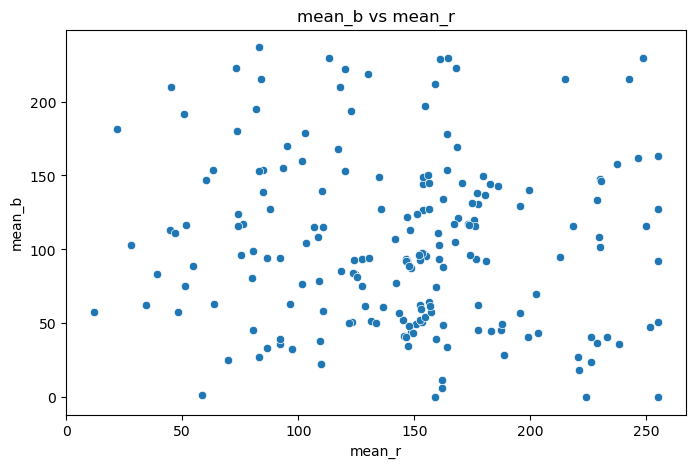

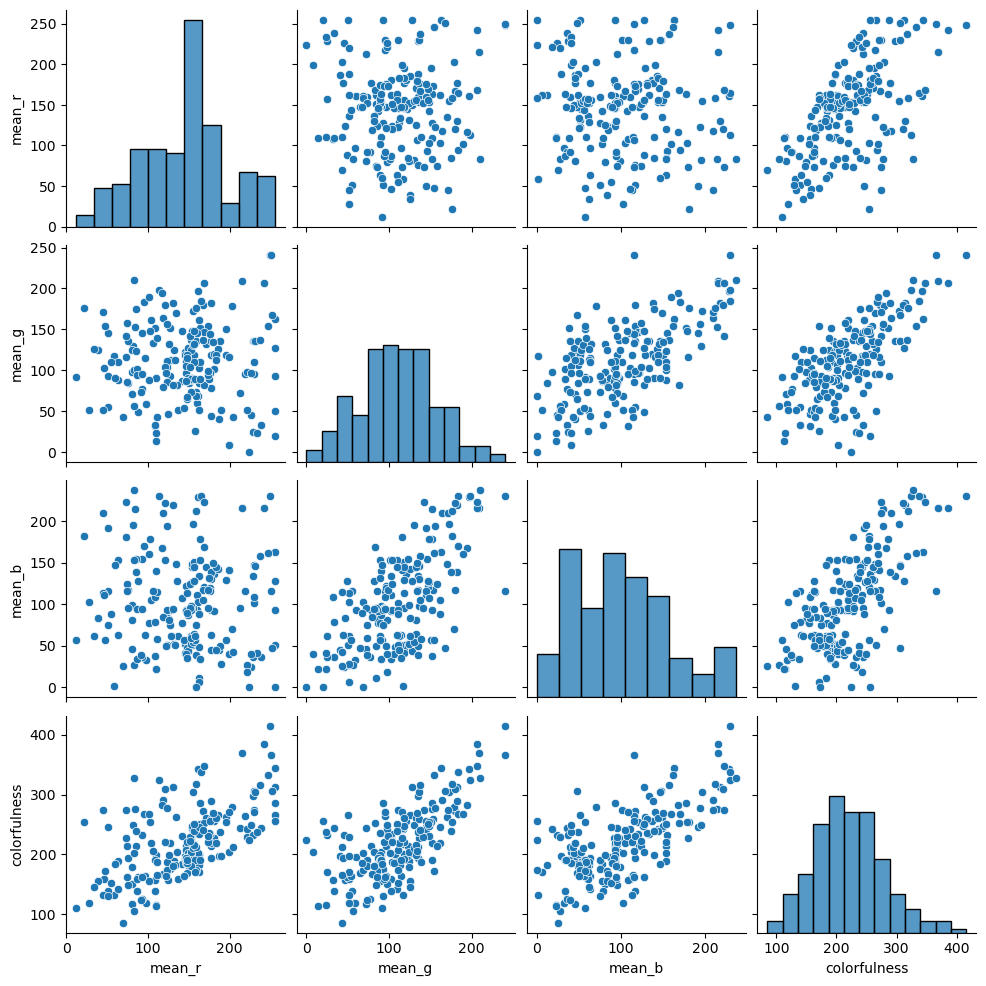

In [10]:
viz.plot_relationships()

### Scatter Plot: `mean_b` vs `mean_r`

This scatter plot compares the average blue (`mean_b`) and red (`mean_r`) color intensities across all flags.

- The points are widely scattered without a clear linear trend, indicating **low correlation** between red and blue channel dominance.
- Flags appear to use red and blue **independently**, meaning a flag rich in red is not necessarily rich in blue, and vice versa.
- This supports the idea that red and blue are often used in contrast or combination with other features, not uniformly together.

**Conclusion**: There is no strong relationship between how much red and blue is used in flag designs.

---

### Pair Plot: `mean_r`, `mean_g`, `mean_b`, and `colorfulness`

This matrix of scatter plots and histograms allows exploration of **pairwise relationships** among the three color channels and the overall colorfulness score.

- **Diagonal plots** show histograms for each feature, with:
  - `mean_r` and `mean_g` showing slight skewness.
  - `colorfulness` appearing normally distributed.
- **Scatter plots** off-diagonal reveal:
  - **Strong positive correlation** between each RGB mean and colorfulness, especially `mean_g` and `mean_b`.
  - Moderate correlations among the RGB means, suggesting that colorful flags often use all channels but not uniformly.

**Conclusion**: Colorfulness is strongly driven by the combined intensity of RGB components, and there's visible structure in how color values co-occur across flags.


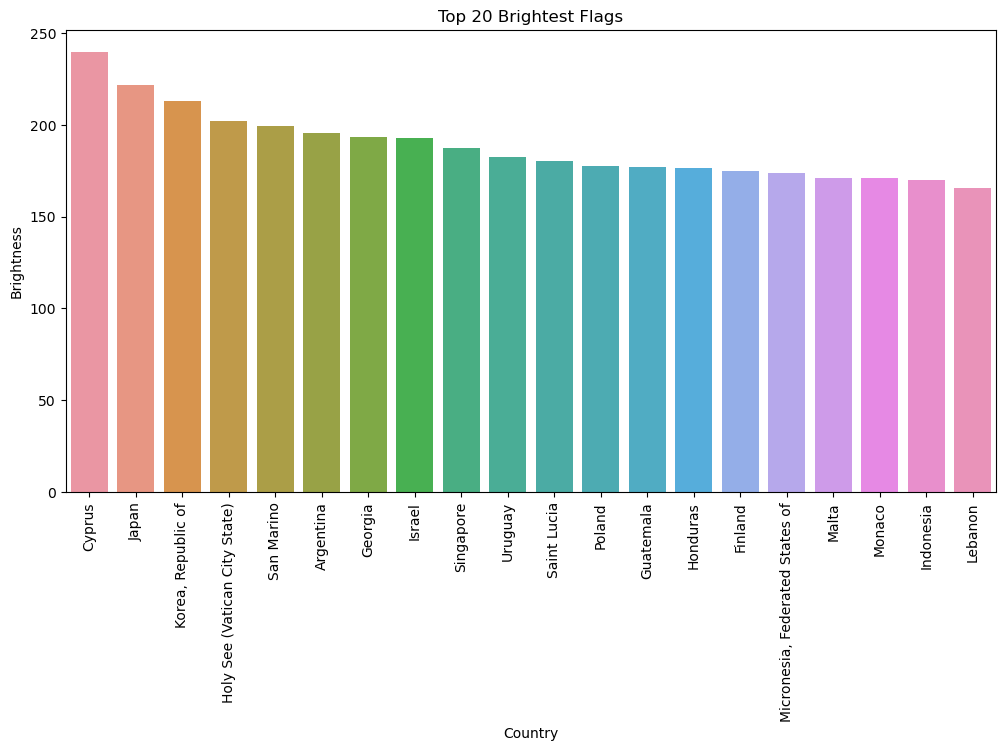

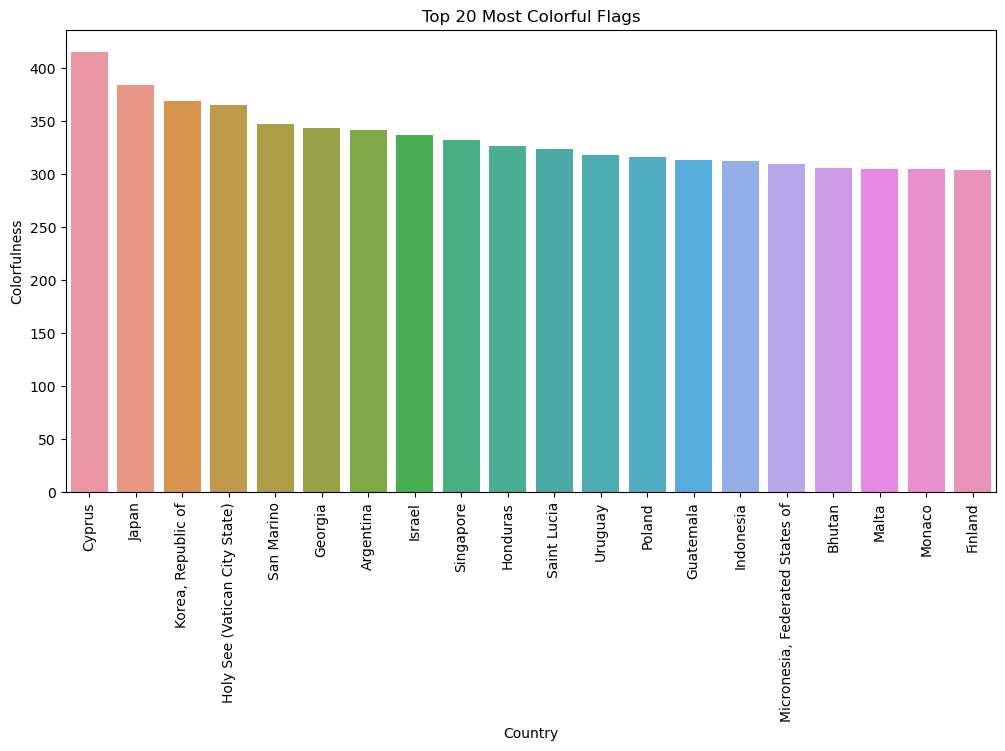

In [11]:
viz.plot_top_flags()

### Top 20 Brightest Flags

This bar chart ranks the 20 brightest flags based on the average of their red, green, and blue color channel means.

- **Cyprus** tops the list, followed closely by **Japan** and **South Korea**, all having very light or white backgrounds.
- Most of the top entries feature significant white or bright color elements, such as **Holy See (Vatican City State)**, **San Marino**, and **Finland**.
- These flags tend to have high visibility and minimal dark features.

**Conclusion**: Brightness is dominated by flags that use large areas of white or very light hues, which contributes to higher average pixel intensity across the RGB channels.

---

### Top 20 Most Colorful Flags

This chart displays the flags with the highest **colorfulness**, calculated as the Euclidean norm of the mean RGB values.

- **Cyprus**, **Japan**, and **South Korea** again appear at the top, showing that flags can be both bright and colorful.
- However, other countries like **Bhutan**, **Indonesia**, and **Guatemala** rank high due to the use of **vivid contrasting colors**.
- High colorfulness doesn't always mean brightness — some flags use bold dark and bright tones in combination.

**Conclusion**: The most colorful flags are those with strong primary color presence and vivid contrast, making them visually striking regardless of overall brightness.

---

**Insight**: Several flags appear in both charts, suggesting a **positive relationship between brightness and colorfulness**, which was also supported by earlier scatter plots.


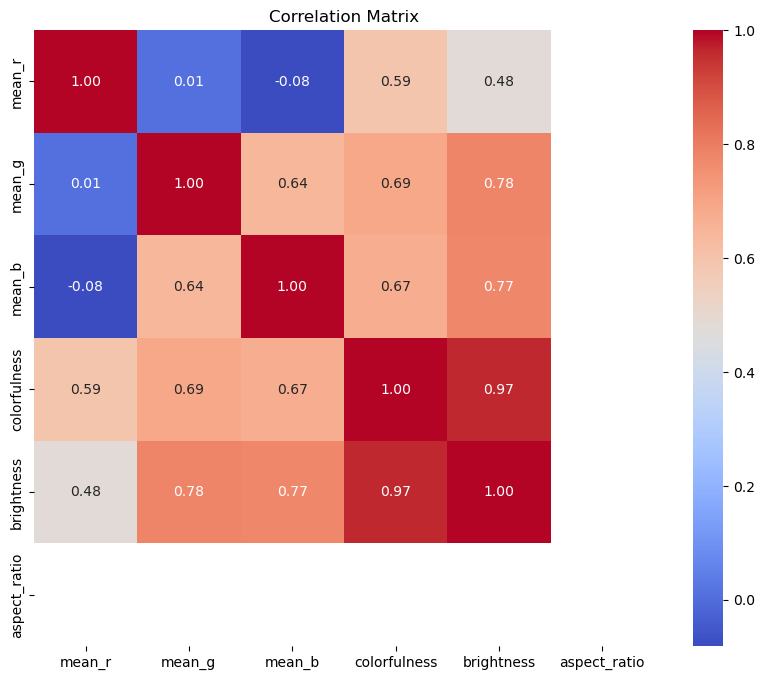

Dominant Color Counts:
Red      127
Blue      38
Green     30
Name: dominant_color, dtype: int64


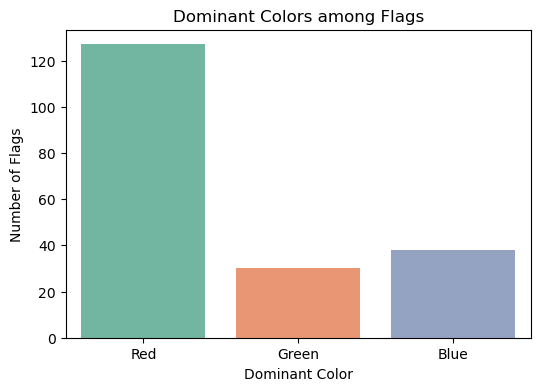

In [12]:
analyzer.plot_correlation_matrix()
analyzer.find_dominant_colors()

### Correlation Matrix Analysis

This heatmap shows the pairwise correlation coefficients between key features extracted from the flag images:

- **Strongest correlations**:
  - `colorfulness` and `brightness`: **0.97** — this indicates that brighter flags are also perceived as more colorful, which makes intuitive sense since high RGB values often increase both metrics.
  - `brightness` also correlates strongly with `mean_g` (0.78) and `mean_b` (0.77), slightly less with `mean_r` (0.48).

- **Moderate correlations**:
  - `colorfulness` with all three RGB means: around **0.59–0.69**, showing that all three color channels contribute to the perceived richness of color.

- **Negligible or negative correlation**:
  - `mean_r` and `mean_b`: **-0.08**, suggesting that red and blue are often used independently or in contrast.

- **aspect_ratio** shows no meaningful correlation with any color metric — as expected, since we resized all images to uniform dimensions.

**Conclusion**: The color features are internally consistent, with colorfulness and brightness being the most tightly linked metrics. Red and blue show low mutual correlation, reflecting diverse flag design choices.

---

### Dominant Color Distribution

The bar chart and counts reveal the frequency of each dominant color (based on which RGB channel has the highest mean) across all flags:

- **Red** is the most common dominant color, present in **127 flags** (~65%).
- **Blue** appears as the dominant color in **38 flags**.
- **Green** is dominant in just **30 flags**, making it the least frequent among the three.

**Conclusion**: Red is by far the most used dominant color in world flags, likely due to its high visibility, cultural significance, and historical symbolism. Blue and green, while still present, are less frequently the primary color in flag designs.


In [13]:
viz.find_top_red_flags()

Top 10 Red Dominant Flags:
                           country    mean_r
110                      Indonesia  255.0000
65                      Kyrgyzstan  255.0000
61                         Georgia  255.0000
37                     Switzerland  255.0000
175                         Canada  255.0000
146                         Bhutan  251.5983
181  Holy See (Vatican City State)  249.8291
8                           Cyprus  248.7381
83                       Singapore  246.5184
87                           Japan  242.3548


### Top 10 Red-Dominant Flags

The following countries have the highest average red channel intensity (`mean_r`) among all flags in the dataset. These flags are visually dominated by strong red components:

| Rank | Country                         | Mean Red (mean_r) |
|------|----------------------------------|-------------------|
| 1    | Indonesia                        | 255.0000          |
| 2    | Kyrgyzstan                       | 255.0000          |
| 3    | Georgia                          | 255.0000          |
| 4    | Switzerland                      | 255.0000          |
| 5    | Canada                           | 255.0000          |
| 6    | Bhutan                           | 251.5983          |
| 7    | Holy See (Vatican City State)    | 249.8291          |
| 8    | Cyprus                           | 248.7381          |
| 9    | Singapore                        | 246.5184          |
| 10   | Japan                            | 242.3548          |

**Observation**:
- The top 5 flags reach the maximum red intensity of **255**, indicating that a large portion of their pixels are pure red.
- These flags often use red in bold areas like central symbols, crosses, or solid halves.

**Conclusion**:
Red is a powerful design choice, often used for its visual dominance, symbolism of strength or bravery, and national identity.


In [14]:
viz.find_top_blue_flags()

Top 10 Blue Dominant Flags:
                             country    mean_b
93                          Honduras  236.7796
75                            Israel  229.7279
30                       Saint Lucia  229.5338
23                         Argentina  228.5787
141                       San Marino  222.7948
124                          Somalia  222.4640
135  Micronesia, Federated States of  221.8050
81                         Guatemala  218.5969
71                Korea, Republic of  215.5577
4                          Nicaragua  214.9622


### Top 10 Blue-Dominant Flags

This table highlights the flags with the highest average blue channel intensity (`mean_b`), meaning blue is the most prominent color visually. 
**Observation**:
- These countries often use shades of **sky blue or navy** prominently in their flag backgrounds, borders, or symbols.
- Several flags (e.g. **Honduras**, **Argentina**, **Guatemala**) feature blue and white as dominant themes.

**Conclusion**:
Blue is frequently associated with **peace**, **freedom**, and **oceanic or sky symbolism**, which explains its presence in many national flags, particularly from the Americas and island nations.


/Users/agrigoryan/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster Assignments:
                                   country  cluster
0                                     Togo        1
1                               Montenegro        1
2  Laos (Lao People's Democratic Republic)        3
3                               Mauritania        3
4                                Nicaragua        0


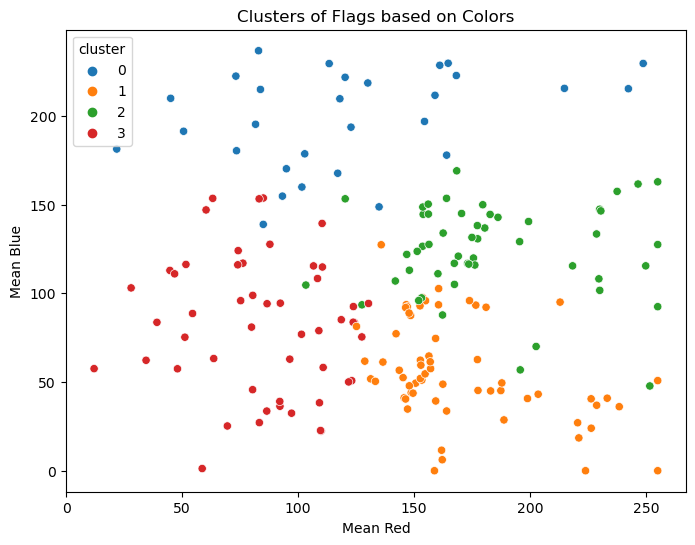

In [15]:
viz.cluster_flags()

### K-Means Clustering of Flags Based on Color Features

The scatter plot above visualizes the result of applying **K-Means clustering (K=4)** to the flags using four features: `mean_r`, `mean_g`, `mean_b`, and `colorfulness`. The x-axis represents the average red channel intensity (`mean_r`), and the y-axis shows the average blue channel intensity (`mean_b`), while color indicates cluster assignment.

Each cluster groups flags with similar color characteristics.

#### Observations:

- **Cluster 0 (Blue points)**: 
  - Positioned higher in the `mean_b` axis.
  - Represents flags with **dominantly blue tones**, such as Nicaragua, Guatemala, and Honduras.

- **Cluster 1 (Orange points)**: 
  - Flags with **high red but relatively low blue**, often vivid and warm-colored flags.
  - Includes countries like **Togo** and **Montenegro**.

- **Cluster 2 (Green points)**: 
  - Balanced red and blue intensities, possibly more colorful or diverse palettes.
  - Includes flags like **Argentina**, **Uruguay**, and **Korea**.

- **Cluster 3 (Red points)**: 
  - Lower values of both red and blue.
  - Often darker or more muted flags.

#### Conclusion:
This clustering offers insight into how countries' flags group visually based on color features. It can help identify color trends and regional or cultural preferences in flag design.


In [16]:
viz.find_most_variable_flags()

Top 10 Most Variable Flags:
                  country   std_total
100              Slovenia  118.693865
194            Tajikistan  112.135888
43                  Yemen  112.135870
20   United Arab Emirates  111.597181
106               Estonia  110.844868
131  Syrian Arab Republic  109.905878
112                 Egypt  109.888804
109                  Iraq  109.768983
167              Malaysia  106.579787
125               Croatia  106.476499


### Top 10 Most Variable Flags

This list ranks flags based on their overall color variability, calculated as the average standard deviation across the red, green, and blue channels (`std_total`). A higher value indicates more **color complexity or diversity** in the flag design.

#### Observations:
- Flags like **Slovenia** and **Tajikistan** exhibit high color variance, which may result from multi-colored sections, symbols, or patterns.
- Many of these flags include **horizontal or vertical stripes**, **crests**, or **multiple graphical elements**, contributing to their high variability.

#### Conclusion:
Color variability is often linked to the **complexity and richness of flag designs**. Flags with high variability tend to use multiple strong colors or include intricate emblems and symbols.


In [17]:
viz.find_brightest_and_darkest_flags()

Brightest Flags:
                           country  brightness
8                           Cyprus  239.688033
87                           Japan  221.559833
71              Korea, Republic of  213.092867
181  Holy See (Vatican City State)  202.060700
141                     San Marino  199.319800

Darkest Flags:
              country  brightness
171             Libya   45.728633
145            Angola   48.576400
122  Papua New Guinea   51.912767
67       Saudi Arabia   53.826833
70              Kenya   55.671100


### Brightest and Darkest Flags

The following tables display the top 5 brightest and darkest flags, based on the average of their red, green, and blue channel intensities (`brightness`). A higher value indicates a lighter overall appearance, while lower values correspond to darker flags.

- These flags use large areas of **white, yellow, or pastel tones**.
- Bright designs often symbolize **peace, neutrality, or clarity**.

#### Darkest Flags

- These flags prominently feature **black, deep red, or dark green**.
- Darker palettes often reflect **power, heritage, or cultural symbolism**.

#### Conclusion
The brightness distribution highlights global contrasts in flag design philosophies, from minimalist white-dominated layouts to bold, darker themes representing strength or identity.


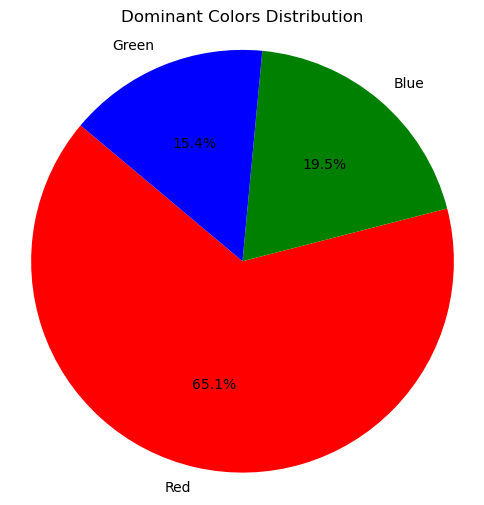

In [18]:
viz.plot_dominant_color_pie()

### Dominant Colors Distribution in Flags

The pie chart shows the proportion of flags where red, green, or blue is the **dominant color**, determined by the highest average RGB channel value in each flag.

#### Distribution:
- **Red**: 65.1% of flags  
- **Blue**: 19.5% of flags  
- **Green**: 15.4% of flags  

#### Interpretation:
- **Red** is overwhelmingly dominant, used in nearly two-thirds of all flags. This suggests its strong symbolic role in national identity, often associated with **valor, revolution, or heritage**.
- **Blue** and **Green** follow with significantly smaller shares, symbolizing values like **freedom, peace, and nature** in specific regions or cultures.

#### Conclusion:
The analysis highlights how **red is the most favored dominant color globally**, shaping the visual and cultural identity of most national flags.


In [19]:
print(" Flags and Symbol Detection (1 = symbol present, 0 = no symbol):")
df = pd.DataFrame(features_df[['country', 'has_symbol']])
df.tail(20)

 Flags and Symbol Detection (1 = symbol present, 0 = no symbol):


,country,has_symbol
175,Canada,0.5
176,Bangladesh,1.0
177,Bahamas,0.0
178,Nigeria,0.0
179,North Macedonia,0.5
180,Nepal,1.0
181,Holy See (Vatican City State),1.0
182,Uzbekistan,1.0
183,Saint Vincent and the Grenadines,1.0
184,Zimbabwe,0.5


### Symbol Detection Results on Flags

This table shows the **symbol detection status** for the last 20 flags in the dataset. The analysis uses a two-stage detection logic to determine whether a flag contains a central symbol or emblem.

#### Legend:
- **1.0** — Symbol is **clearly detected** (both vertical and horizontal tests pass).
- **0.5** — Symbol is **weakly detected** (only one of the two tests passed).
- **0.0** — **No symbol detected** (both tests failed).

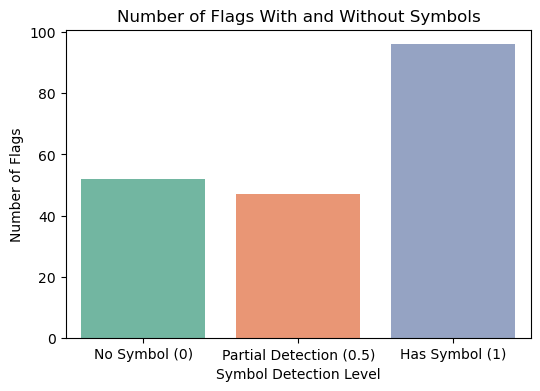

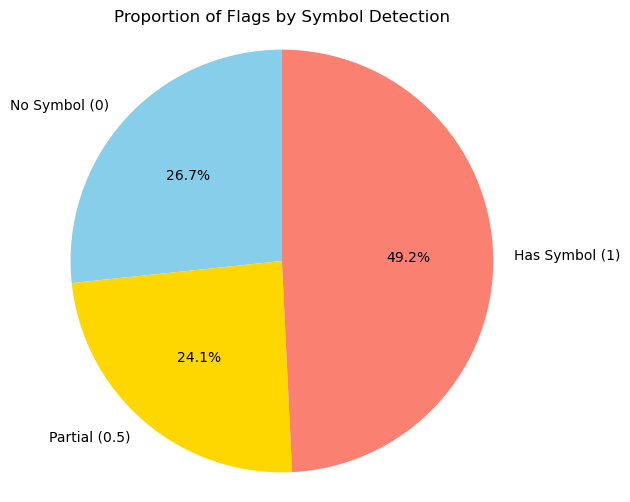

In [20]:
viz.has_symbol_display()

### Symbol Detection Analysis in Flags

The visualizations below break down how symbols are detected in national flags using a three-level detection system:

- **0**: No symbol detected (both vertical and horizontal checks failed).
- **0.5**: Partial detection (only one axis indicated potential symbol presence).
- **1**: Symbol confidently detected (both axes showed high volatility indicating a symbol).

#### Symbol Presence Distribution (Bar Plot)

The bar chart shows the count of flags falling into each detection category.

- **Has Symbol (1)**: Majority of the flags fall in this category, with over 90 flags having strong symbol presence.
- **Partial Detection (0.5)**: Around 48 flags showed ambiguous symbol-like patterns.
- **No Symbol (0)**: About 52 flags did not exhibit enough visual complexity to infer a symbol.

#### Symbol Detection Proportion (Pie Chart)

This pie chart illustrates the proportion of flags with and without symbols:

- Almost **half (49.2%)** of all flags have clearly identifiable symbols.
- **24.1%** exhibit partial symbol detection.
- **26.7%** have no symbols.

These results highlight that while a large number of flags use symbols, a significant portion are purely composed of geometric patterns or colors.


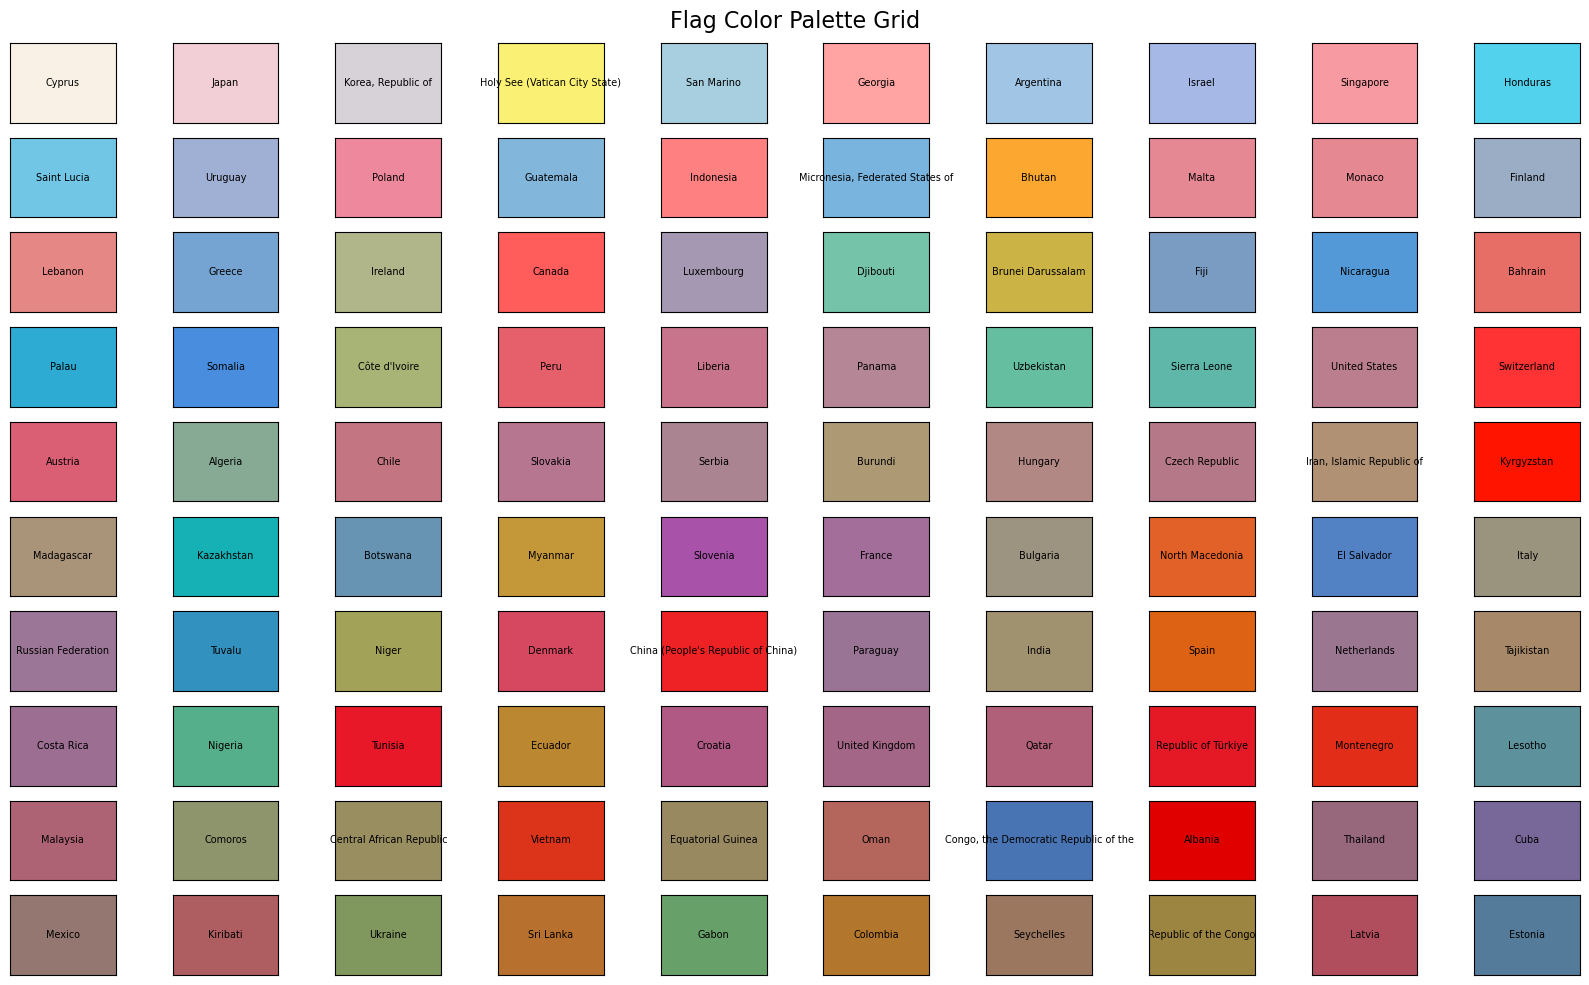

In [21]:
viz.plot_color_palette_grid()

### Flag Color Palette Grid

This visualization presents a compact and aesthetic overview of flag colors by mapping each country’s flag to a colored box based on its average RGB values.

---

#### What It Shows:
- **Each square** represents a flag.
- **Background color** of the square is the **average RGB color** computed from that flag’s pixels.
- **Country names** are displayed inside each square.
- **Layout** is a configurable grid (default is 10x10), typically sorted by colorfulness for visual clarity.

---

####  Purpose:
-   **Visual Overview** – Quickly grasp the color tendencies of national flags.
-   **Color Trends** – Observe regional or cultural preferences (e.g., heavy use of red or blue).
-   **Memory Aid** – Makes it easy to remember how colorful or monochromatic a flag is.
-   **Presentation-Friendly** – Ideal summary slide to showcase dataset diversity or feature analysis.

---

This grid complements statistical plots by giving an **intuitive visual sense** of flag datasets.


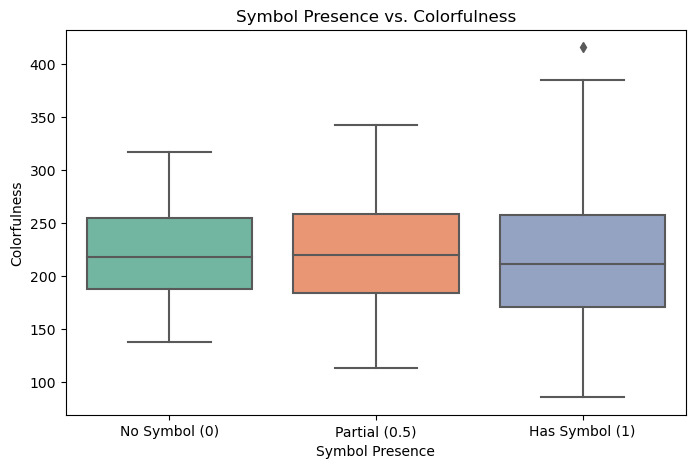

In [22]:
viz.plot_symbol_vs_colorfulness_boxplot()

###   Symbol Presence vs. Colorfulness

This boxplot compares the colorfulness of flags based on their symbol presence classification.

---

####   What It Represents:
- **X-axis:** Symbol presence category:
  - `0` = No Symbol
  - `0.5` = Partial detection (symbol identified with weaker evidence)
  - `1` = Clear Symbol presence
- **Y-axis:** Colorfulness score (computed as the Euclidean norm of mean RGB values).

---

####  Insights:
- Flags with or without symbols have **similar median colorfulness** values.
- Flags with a clear symbol (`1`) show **wider variability**, meaning they can be either very vibrant or quite plain.
- Flags without symbols (`0`) tend to be **more consistent** in color range.

---

####   Purpose:
- Investigates whether the **presence of symbols influences color design** choices.
- Highlights that flags with symbols may require higher contrast or distinct hues to **emphasize emblem visibility**.

 This analysis helps bridge symbolic design with visual intensity and cultural identity.
